# Жанровая классификация аудио

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import glob

import json

from functools import reduce
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

from keras.backend import clear_session
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger, BackupAndRestore

from dataclasses import dataclass
from keras.utils import Sequence

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Фильтрация метаданных

In [105]:
DATA_DIR = './data/fma_small'
METADATA_DIR = './data/fma_metadata/'

mp3_files = glob.glob(DATA_DIR + '/*/*.mp3')
mp3_names = list(map(lambda f: np.int64(f.split('/')[-1].split('.')[0]), mp3_files))

raw_tracks = pd.read_csv(METADATA_DIR + 'raw_tracks.csv')
tracks = raw_tracks[raw_tracks['track_id'].isin(mp3_names)]

## Сбор признаков, полученных с помощью `librosa`

In [106]:
features_df = pd.read_csv(METADATA_DIR + 'features.csv', index_col=0, header=[0, 1, 2])
features_df = features_df[features_df.index.isin(mp3_names)]

features = np.unique(list(map(lambda x: x[0], list(features_df.columns))))

print(f"Features available: {features}")
print(f"Total: {len(features)}")

features_df

Features available: ['chroma_cens' 'chroma_cqt' 'chroma_stft' 'mfcc' 'rmse'
 'spectral_bandwidth' 'spectral_centroid' 'spectral_contrast'
 'spectral_rolloff' 'tonnetz' 'zcr']
Total: 11


feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
140           0.533579 -0.623885 -1.086205 -1.081079 -0.765151 -0.072282   
141           0.172898 -0.284804 -1.169662 -1.062855 -0.706868 -0.708281   
...                ...       ...       ...       ...       ...       ...   
154308       -0.677709 -0.830608 -0.686122  0.185158  2.854806 -1.131797   
154309       -0.585059 -0.635075 -0.194742 -0.434809 -1.357310 -0.257745   
154413       -0.214509 -1.130469  0.718534 -0.368448 -0.147830 -0.099409   
154414       -0.487371 -0.923754 -0.283099 -0.435221 -1.137329 -0.798039   
155066        0.044216 -0.300441 -0.217022 -0.356106 -1.085789 -1.185135   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
140        -0.882913 -0.582376 -0.884749 -0.645214  ...  0.157683  0.028070   
141        -0.204884  0.023624 -0.642770 -0.786291  ...  0.145994  0.024342   
...              ...       ...       ...       ...  ...       ...       ...   
154308     -1.161222 -1.110237 -0.818111 -1.388484  ...  0.117287  0.021906   
154309     -0.639082 -0.572640 -1.225242  5.548715  ...  0.180397  0.029303   
154413     -1.325709 -0.105248 -1.363881  1.229534  ...  0.156587  0.036926   
154414     -0.258168  1.004049 -0.499121  0.746973  ...  0.181294  0.026723   
155066     -0.655948 -1.517006 -0.490595 -1.267883  ...  0.189816  0.029439   

feature                      zcr                                          \
statistics              kurtosis       max      mean    median       min   
number            06          01        01        01        01        01   
track_id                                                                   
2           0.012111    5.758890  0.459473  0.085629  0.071289  0.000000   
5           0.014759    6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921   21.434212  0.452148  0.077515  0.071777  0.000000   
140         0.025946   11.052547  0.379395  0.052379  0.036621  0.001953   
141         0.032111   32.994659  0.415527  0.040267  0.034668  0.002930   
...              ...         ...       ...       ...       ...       ...   
154308      0.021999   53.807804  0.769043  0.042997  0.022949  0.001953   
154309      0.023771   12.597441  0.768555  0.082979  0.037109  0.008789   
154413      0.038113   25.368595  0.323242  0.024532  0.018066  0.000977   
154414      0.030980   21.276468  0.511230  0.046116  0.033691  0.003418   
155066      0.025806  116.044044  0.554199  0.016058  0.009766  0.000000   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
5           2.193303  0.044861  
10          3.542325  0.040800  
140         3.143968  0.057712  
141         4.204097  0.028665  
...              ...       ...  
154308      6.928385  0.084298  
154309      3.441251  0.129480  
154413      3.736646  0.023821  
154414      3.997052  0.045733  
155066      9.688635  0.030787  

[8000 rows x 518 columns]

## Отбор признаков

Рассмотрим всю имеющуюся информацию о треках

In [107]:
tracks.columns

Index(['track_id', 'album_id', 'album_title', 'album_url', 'artist_id',
       'artist_name', 'artist_url', 'artist_website', 'license_image_file',
       'license_image_file_large', 'license_parent_id', 'license_title',
       'license_url', 'tags', 'track_bit_rate', 'track_comments',
       'track_composer', 'track_copyright_c', 'track_copyright_p',
       'track_date_created', 'track_date_recorded', 'track_disc_number',
       'track_duration', 'track_explicit', 'track_explicit_notes',
       'track_favorites', 'track_file', 'track_genres', 'track_image_file',
       'track_information', 'track_instrumental', 'track_interest',
       'track_language_code', 'track_listens', 'track_lyricist',
       'track_number', 'track_publisher', 'track_title', 'track_url'],
      dtype='object')

Оценим число непустых значений тегов

In [108]:
tracks['tags'].map(lambda x: None if x == '[]' else x).notnull().value_counts()

False    6639
True     1361
Name: tags, dtype: int64

Подсчитаем число уникальных тегов

In [109]:
unique_tags = reduce(lambda tags, l: tags.union(eval(l)), tracks['tags'], set())
print(len(unique_tags))

1191


Оставим предположительно полезную информацию из набора данных. Убедимся
в её необходимости позже.

In [110]:
to_keep = [
  'track_id', "album_id", "artist_id", "track_duration", 
  "track_genres", "track_instrumental", "track_interest", "track_listens",
]

filtered_tracks = tracks[to_keep]
filtered_tracks

,track_id,album_id,artist_id,track_duration,track_genres,track_instrumental,track_interest,track_listens
0,2,1.0,1,02:48,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4656,1293
2,5,1.0,1,03:26,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,1933,1151
3,10,6.0,6,02:41,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen...",0,54881,50135
15,140,61.0,54,04:13,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,1593,1299
16,141,60.0,54,03:02,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,839,725
...,...,...,...,...,...,...,...,...
108843,154308,22780.0,23208,03:14,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,3371,2705
108844,154309,22780.0,23208,02:42,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4525,3589
108945,154413,22789.0,24252,05:49,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,809,676
108946,154414,22789.0,24252,05:46,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,851,788


Преобразуем время в секунды

In [111]:
def duration_to_int(t):
  splitted = t.split(":")
  
  return int(splitted[0]) * 60 + int(splitted[1])

filtered_tracks.loc[:,'track_duration'] = filtered_tracks.track_duration.apply(duration_to_int)
filtered_tracks

/tmp/ipykernel_3384/3619144929.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tracks.loc[:,'track_duration'] = filtered_tracks.track_duration.apply(duration_to_int)
/tmp/ipykernel_3384/3619144929.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  filtered_tracks.loc[:,'track_duration'] = filtered_tracks.track_duration.apply(duration_to_int)


,track_id,album_id,artist_id,track_duration,track_genres,track_instrumental,track_interest,track_listens
0,2,1.0,1,168,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4656,1293
2,5,1.0,1,206,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,1933,1151
3,10,6.0,6,161,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen...",0,54881,50135
15,140,61.0,54,253,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,1593,1299
16,141,60.0,54,182,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,839,725
...,...,...,...,...,...,...,...,...
108843,154308,22780.0,23208,194,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,3371,2705
108844,154309,22780.0,23208,162,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4525,3589
108945,154413,22789.0,24252,349,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,809,676
108946,154414,22789.0,24252,346,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,851,788


Узнаем количество жанров для треков

In [112]:
genres = filtered_tracks['track_genres'].map(lambda x: json.loads(x.replace("'", "\"")))
genre_ids = genres.map(lambda x: list(map(lambda y: y['genre_id'], x)))
genre_ids.map(lambda x: len(x)).value_counts()

1    4256
2    2362
3    1304
4      41
5      32
6       5
Name: track_genres, dtype: int64

Определим базовые жанры для каждого трека

In [113]:
all_genres = pd.read_csv(METADATA_DIR + 'genres.csv')

base_genres = genre_ids.map(lambda x: all_genres[all_genres.genre_id == int(x[0])].iloc[0].top_level)

filtered_tracks['track_genres'] = base_genres
filtered_tracks

/tmp/ipykernel_3384/3932000545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tracks['track_genres'] = base_genres


,track_id,album_id,artist_id,track_duration,track_genres,track_instrumental,track_interest,track_listens
0,2,1.0,1,168,21,0,4656,1293
2,5,1.0,1,206,21,0,1933,1151
3,10,6.0,6,161,10,0,54881,50135
15,140,61.0,54,253,17,0,1593,1299
16,141,60.0,54,182,17,0,839,725
...,...,...,...,...,...,...,...,...
108843,154308,22780.0,23208,194,21,0,3371,2705
108844,154309,22780.0,23208,162,21,0,4525,3589
108945,154413,22789.0,24252,349,10,0,809,676
108946,154414,22789.0,24252,346,10,0,851,788


In [114]:
base_genres.value_counts()

21      1000
10      1000
17      1000
38      1000
12      1000
2       1000
15      1000
1235    1000
Name: track_genres, dtype: int64

Получили 8 сбалансированных классов

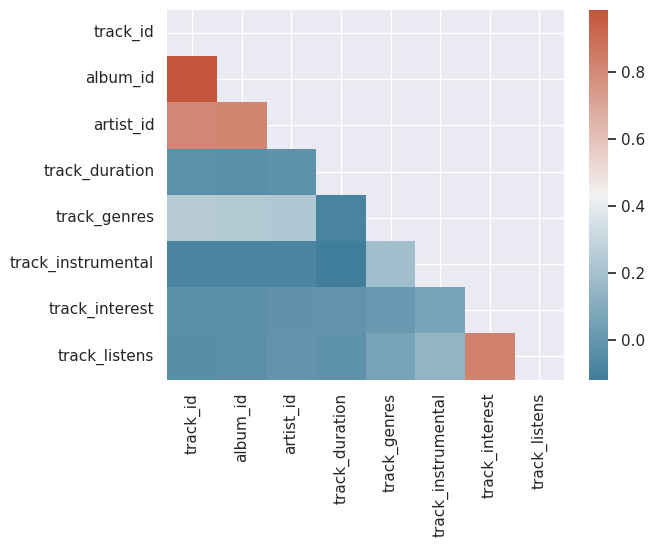

In [115]:
def display_corr(df):
  corr = df.corr()
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  mask = np.triu(np.ones_like(corr, dtype=bool))
  sns.heatmap(corr, mask=mask, cmap=cmap)
  
display_corr(filtered_tracks)

Жанр трека очень плохо коррелирует с его длительностью, поэтому исключим
этот признак из рассмотрения

In [116]:
filtered_tracks = filtered_tracks.drop('track_duration', axis=1)

Теперь добавим значения, предпосчитанные с помощью `librosa`

/tmp/ipykernel_3384/1369159907.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (3 levels on the left, 1 on the right)
  merged = features_df.merge(filtered_tracks, how='inner', on='track_id')


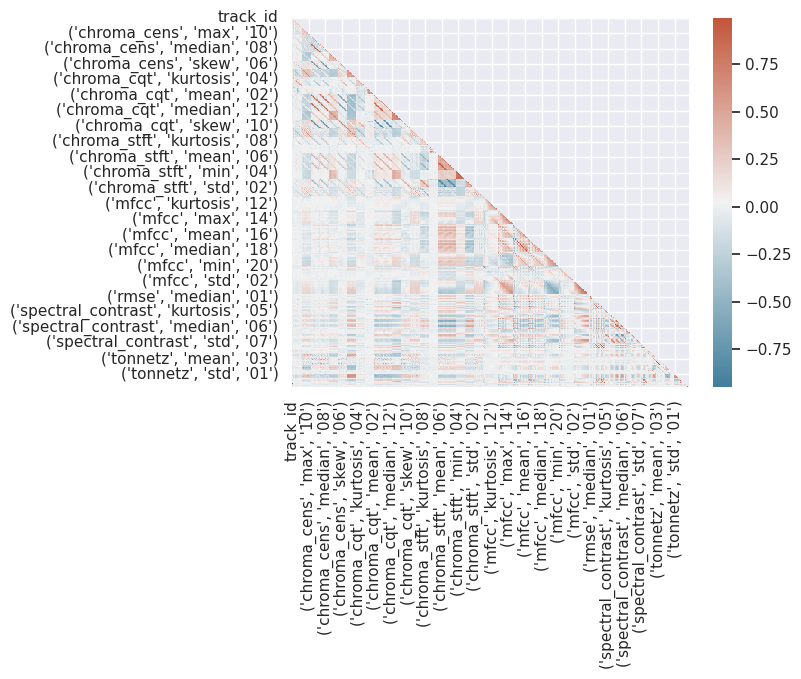

In [117]:
merged = features_df.merge(filtered_tracks, how='inner', on='track_id')

display_corr(merged)

Конечно, признаков слишком много. Из всех возьмем признаки с наибольшей по
модулю корреляцией.

Для этого отсортируем признаки по степени корреляции

In [118]:
correlation = merged.corr()

genres_corr = correlation['track_genres'].sort_values(key=lambda x: np.abs(x), ascending=False)
genres_corr

track_genres                        1.000000
(spectral_bandwidth, median, 01)   -0.340123
(spectral_bandwidth, mean, 01)     -0.335322
(mfcc, mean, 01)                   -0.331284
(spectral_contrast, mean, 07)      -0.328257
                                      ...   
(chroma_cens, kurtosis, 10)         0.001003
(mfcc, skew, 18)                    0.000923
(chroma_cens, skew, 09)             0.000667
(mfcc, median, 09)                  0.000328
(chroma_cens, kurtosis, 03)         0.000273
Name: track_genres, Length: 525, dtype: float64

Изобразим распределение значений корреляции

<Axes: xlabel='track_genres', ylabel='Count'>

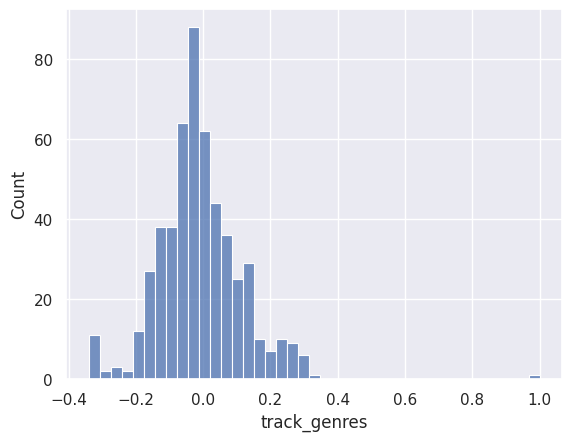

In [119]:
sns.histplot(genres_corr)

Видно, что наибольшее число признаков имеют почти нулевую корреляцию.
В связи с этим выберем наиболее информативные из них

In [120]:
boundary = 0.2

selected = merged[genres_corr[abs(genres_corr) > boundary].reset_index()['index']]
selected.set_index('track_id', inplace=True)

Кроме того, удалим сильно коррелирующие друг с другом нецелевые признаки,
оставив среди таких пар те, что больше коррелируют с целевым

In [121]:
c = selected.corr()

to_be_excluded = set()

boundary = 0.9

for i in c:
  for j in c:
    if abs(c[i][j]) > boundary and i != j and i != 'track_genres' and j != 'track_genres':
      least_informative = i if c['track_genres'][i] < c['track_genres'][j] else j
      to_be_excluded.add(least_informative)
      
to_be_excluded

{('mfcc', 'mean', '01'),
 ('mfcc', 'mean', '02'),
 ('mfcc', 'mean', '04'),
 ('mfcc', 'median', '03'),
 ('mfcc', 'median', '06'),
 ('spectral_bandwidth', 'mean', '01'),
 ('spectral_bandwidth', 'median', '01'),
 ('spectral_centroid', 'mean', '01'),
 ('spectral_centroid', 'median', '01'),
 ('spectral_centroid', 'skew', '01'),
 ('spectral_contrast', 'mean', '07'),
 ('spectral_contrast', 'median', '02'),
 ('spectral_contrast', 'median', '03'),
 ('spectral_contrast', 'median', '04'),
 ('spectral_rolloff', 'mean', '01')}

In [122]:
selected = selected.drop(to_be_excluded, axis=1)

Перекодируем метки классов

In [123]:
genre_le = LabelEncoder()

selected.track_genres = genre_le.fit_transform(selected.track_genres)
selected

,track_genres,"(mfcc, median, 01)","(spectral_rolloff, skew, 01)","(spectral_contrast, median, 07)","(mfcc, max, 01)","(spectral_rolloff, median, 01)","(spectral_bandwidth, skew, 01)","(spectral_contrast, max, 07)","(mfcc, max, 04)","(spectral_contrast, mean, 03)",...,artist_id,"(tonnetz, std, 04)","(mfcc, min, 03)","(mfcc, min, 07)","(mfcc, max, 02)","(spectral_contrast, mean, 02)","(mfcc, max, 08)","(zcr, mean, 01)","(rmse, mean, 01)","(mfcc, mean, 06)"
track_id,,,,,,,,,,,,,,,,,,,,,
2,5,-143.594299,0.347372,39.830345,28.657707,3143.847656,-0.884317,54.687260,103.289833,17.129013,...,1,0.054125,-115.315613,-61.748718,215.541351,15.363138,58.169933,0.085629,3.188761,18.879372
5,5,-181.015961,0.266975,39.101978,-40.500740,2863.916016,-0.658707,51.896751,112.312531,18.646988,...,1,0.040730,-87.205124,-59.320251,218.972977,15.969444,57.987415,0.053114,3.251386,16.942802
10,1,-113.085472,1.800220,36.594524,20.196968,2002.587891,0.878823,52.130795,78.466721,15.510051,...,6,0.074358,-130.033524,-44.849060,235.198517,14.281867,42.955067,0.077515,3.893810,13.934344
140,4,-200.058487,0.655808,37.852184,-19.554893,2153.320312,0.091172,52.635704,148.336426,18.562231,...,54,0.157683,-91.350792,-68.356682,218.817322,16.298210,51.864899,0.052379,2.953848,28.328743
141,4,-259.161804,1.430542,31.146515,-31.971275,1658.056641,1.004211,49.282562,108.459908,19.953085,...,54,0.145994,-88.630844,-58.395340,232.621674,18.583612,50.200264,0.040267,2.576761,11.692952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154308,5,-296.399994,2.989810,21.365528,10.407327,1152.026367,1.310098,46.864613,124.703125,19.874151,...,23208,0.117287,-178.103043,-31.414083,283.707458,16.733612,38.486408,0.042997,2.174565,4.368904
154309,5,-388.301178,0.994214,23.360811,-21.851103,1130.493164,0.350365,54.186939,82.278091,22.690062,...,23208,0.180397,-101.862770,-56.105015,269.592011,19.529175,50.166153,0.082979,1.548146,1.173940
154413,1,-224.460236,1.316305,32.489326,-57.707806,1475.024414,1.262819,51.684505,153.485001,20.002176,...,24252,0.156587,-80.218735,-56.207314,238.620834,17.922699,66.826797,0.024532,4.202268,22.758905


In [124]:
selected.columns = selected.columns.map(str)

In [125]:
for column in selected.columns:
  if column == 'track_genres':
    continue
  selected[column] = StandardScaler().fit_transform(selected[column].to_numpy().reshape(-1, 1))

Убедимся, что `StandardScaler` отработал корректно

In [126]:
selected.describe()

,track_genres,"('mfcc', 'median', '01')","('spectral_rolloff', 'skew', '01')","('spectral_contrast', 'median', '07')","('mfcc', 'max', '01')","('spectral_rolloff', 'median', '01')","('spectral_bandwidth', 'skew', '01')","('spectral_contrast', 'max', '07')","('mfcc', 'max', '04')","('spectral_contrast', 'mean', '03')",...,artist_id,"('tonnetz', 'std', '04')","('mfcc', 'min', '03')","('mfcc', 'min', '07')","('mfcc', 'max', '02')","('spectral_contrast', 'mean', '02')","('mfcc', 'max', '08')","('zcr', 'mean', '01')","('rmse', 'mean', '01')","('mfcc', 'mean', '06')"
count,8000.000000,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,...,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03
mean,3.500000,2.273737e-16,-4.618528e-17,-1.385558e-16,-1.065814e-17,1.563194e-16,-7.815970e-17,5.702105e-16,2.842171e-17,2.629008e-16,...,-1.136868e-16,-7.105427e-17,2.557954e-16,-8.526513e-17,4.085621e-16,-3.765876e-16,-1.829648e-16,-2.131628e-17,-1.705303e-16,-6.217249e-17
std,2.291431,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,...,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00
min,0.000000,-7.970248e+00,-1.095442e+01,-2.623073e+00,-1.163158e+01,-1.652957e+00,-1.427370e+01,-4.579266e+00,-3.941956e+00,-3.390965e+00,...,-1.856327e+00,-2.412642e+00,-4.395684e+00,-6.406196e+00,-8.931983e+00,-3.082066e+00,-3.479518e+00,-1.663026e+00,-1.838379e+00,-4.796596e+00
25%,1.750000,-6.038649e-01,-5.645684e-01,-5.836193e-01,-5.091851e-01,-7.247778e-01,-5.563256e-01,-4.197092e-01,-6.408750e-01,-7.028439e-01,...,-8.134367e-01,-7.401046e-01,-6.306006e-01,-6.043270e-01,-5.412937e-01,-6.975963e-01,-6.282162e-01,-6.475547e-01,-7.376613e-01,-5.608036e-01
50%,3.500000,1.216726e-01,-2.553486e-01,1.403841e-01,2.018295e-01,-1.522561e-01,-1.888263e-01,2.130642e-01,4.682082e-02,-1.366630e-01,...,1.209327e-01,-1.195729e-01,3.934132e-03,6.468481e-02,6.373809e-02,-1.353631e-01,-1.992645e-02,-1.668971e-01,-1.134209e-01,8.966895e-02
75%,5.250000,6.996039e-01,2.681449e-01,7.334416e-01,7.026321e-01,5.677334e-01,3.443690e-01,6.647770e-01,6.849368e-01,5.872362e-01,...,9.257628e-01,6.060888e-01,6.127545e-01,6.702968e-01,6.547827e-01,5.682169e-01,6.146821e-01,4.183036e-01,5.811625e-01,6.707833e-01
max,7.000000,3.421958e+00,1.856961e+01,2.787234e+00,2.529067e+00,6.310300e+00,1.625224e+01,2.257328e+00,4.897631e+00,7.646116e+00,...,1.611062e+00,4.760091e+00,3.442668e+00,3.195089e+00,3.130199e+00,7.374279e+00,9.095344e+00,2.032211e+01,6.857885e+00,4.062191e+00


Разделим данные по принципу `train/test/split`

In [127]:
x = selected.drop('track_genres', axis=1).to_numpy()
y = selected['track_genres'].to_numpy()

test_size = 0.2
valid_size = 0.1

X_train, X_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=69, stratify=y)
    
X_train, X_valid, y_train, y_valid = \
    train_test_split(X_train, y_train, test_size=valid_size / (1 - test_size),
                     random_state=69, stratify=y_train)
    
n_classes = np.max(y) + 1

In [128]:
def label2vec(n_classes):
  def inner(label):  
    v = np.zeros(n_classes)
    v[label] = 1
    return v
  return inner

## Сравнение моделей

In [129]:
models = []

### K-Nearest Neighbours

In [130]:
n_classes = np.max(y) + 1
list_of_neighbours = list(map(int, range(1, 300, 5)))

Опишем функцию, которая будет отображать результаты экспериментов

In [131]:
def plot_score(n, scores, names):
    d = {names: n, 'score': scores}
    df = pd.DataFrame(d)

    sns.set(style='darkgrid')
    sns.lineplot(x=names, y='score', data=df)

Вычислим значения `accuracy` для моделей с разным числом соседей

100%|██████████| 60/60 [00:23<00:00,  2.58it/s]


Лучшая модель: 1 соседей, точность: 0.5425


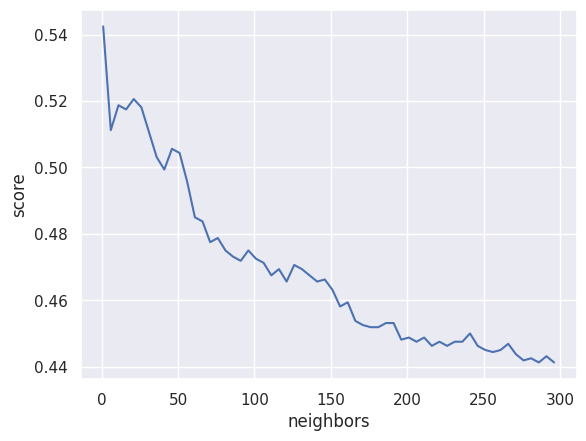

In [132]:
best_n = -1
best_score = -1
scores = []
for n in tqdm(list_of_neighbours):
    knn = KNeighborsClassifier(p=1, n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = knn.score(X_test, y_test)
    
    if score > best_score:
        best_score = score
        best_n = n
    scores.append(score)

plot_score(list_of_neighbours, scores, 'neighbors')
print(f'Лучшая модель: {best_n} соседей, точность: {best_score}')

Конечно, такой метод оценки качества модели не является надежным, лучше воспользоваться
оценкой методом кросс-валидации — `cross_val_score`.

В дальнейшем будем использовать именно этот метод.

100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


Лучшая модель: 46 соседей, точность: 0.44750000000000006


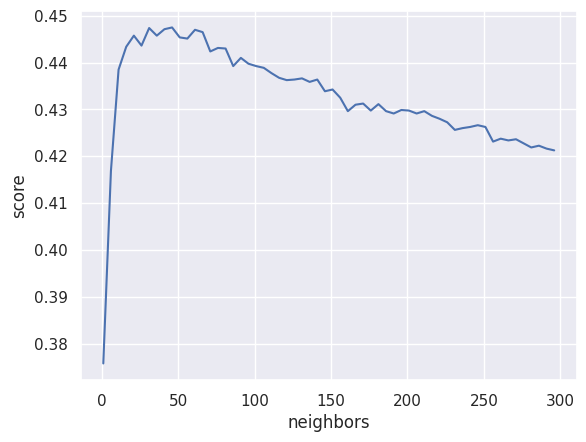

In [133]:
best_n = -1
best_score = -1
scores = []

for n in tqdm(list_of_neighbours):
    knn = KNeighborsClassifier(p=2, n_neighbors=n)
    
    score = cross_val_score(knn, x, y, cv=5).mean()
    
    if score > best_score:
        best_score = score
        best_n = n
    scores.append(score)

plot_score(list_of_neighbours, scores, 'neighbors')
print(f'Лучшая модель: {best_n} соседей, точность: {best_score}')

models.append((KNeighborsClassifier(p=2, n_neighbors=best_n), 'sklearn'))

100%|██████████| 60/60 [00:07<00:00,  7.98it/s]


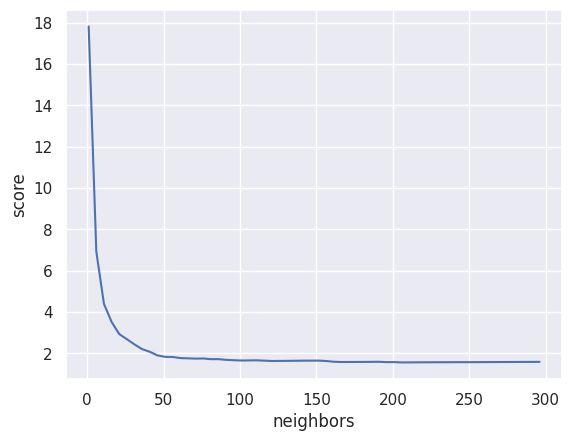

In [134]:
scores = []
for n in tqdm(list_of_neighbours):
    knn = KNeighborsClassifier(p=2, n_neighbors=n)
    knn.fit(X_train, y_train)
    probs = knn.predict_proba(X_test)
    
    loss = log_loss(y_test, probs)
    scores.append(loss)

plot_score(list_of_neighbours, scores, 'neighbors')

### $\nu$-svc

In [150]:
list_of_kernels = ["poly", "rbf", "sigmoid"]
list_of_degree = list(map(int, range(1, 10, 1)))
array_of_percentage_anchor_points = np.arange(0.01, 0.5, 0.01)

100%|██████████| 3/3 [00:47<00:00, 15.98s/it]

Лучшая модель: rbf ядро, точность: 0.481375


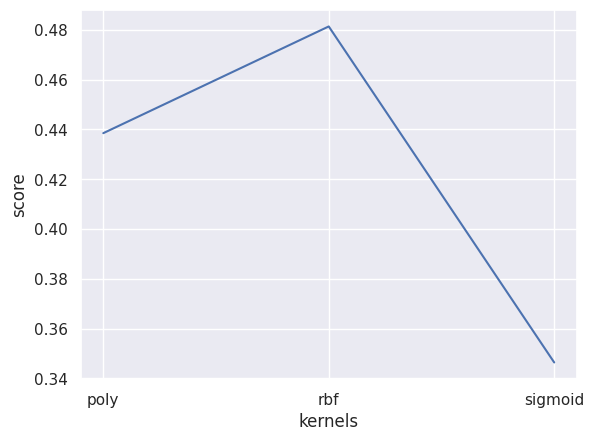

In [144]:
best_k = "poly"
best_score = -1
scores = []
for k in tqdm(list_of_kernels):
    nu_svc = NuSVC(kernel=k)

    score = cross_val_score(nu_svc, x, y, cv=5).mean()
    
    if score > best_score:
        best_score = score
        best_k = k
    scores.append(score)

plot_score(list_of_kernels, scores, 'kernels')
print(f'Лучшая модель: {best_k}-ядро, точность: {best_score}')

100%|██████████| 9/9 [02:10<00:00, 14.49s/it]


Лучшая модель: 1 степень для ядра poly, точность: 0.44262500000000005


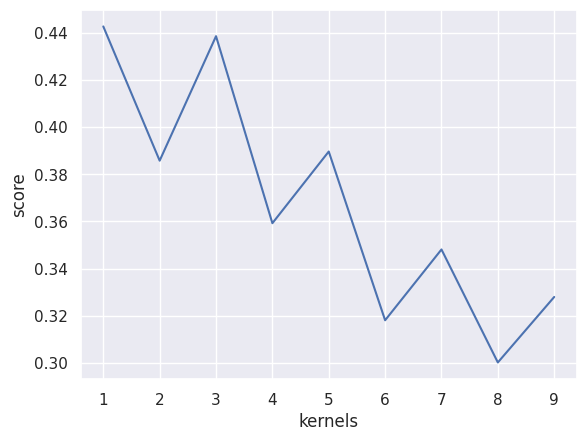

In [145]:
best_d = -1
best_score = -1
scores = []
for d in tqdm(list_of_degree):
    nu_svc = NuSVC(degree=d, kernel="poly")
    
    score = cross_val_score(nu_svc, x, y, cv=5).mean()
    
    if score > best_score:
        best_score = score
        best_d = d
    scores.append(score)

plot_score(list_of_degree, scores, 'degrees')
print(f'Лучшая модель: {best_d} степень для ядра poly, точность: {best_score}')

100%|██████████| 49/49 [12:55<00:00, 15.83s/it]


Лучшая модель: 46.0% тестовой выборки являются опорными      точками, точность: 0.483


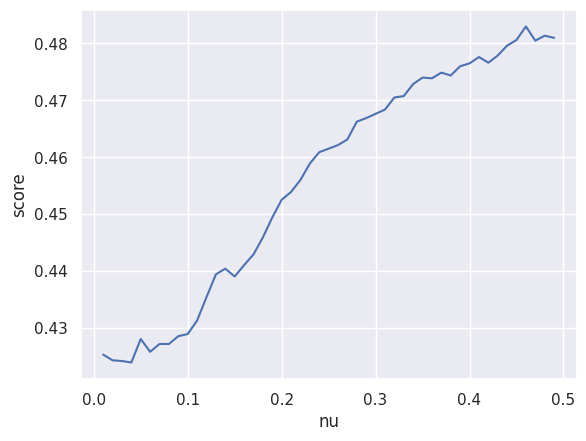

In [151]:
best_nu = -1
best_score = -1
scores = []
for nu in tqdm(array_of_percentage_anchor_points):
    nu_svc = NuSVC(nu=nu)
    
    score = cross_val_score(nu_svc, x, y, cv=5).mean()

    if score > best_score:
        best_score = score
        best_nu = nu
    scores.append(score)

plot_score(array_of_percentage_anchor_points, scores, 'nu')
print(f'''Лучшая модель: {best_nu * 100}% тестовой выборки являются опорными\
      точками, точность: {best_score}''')

models.append((NuSVC(nu=best_nu), 'sklearn'))

100%|██████████| 49/49 [09:01<00:00, 11.05s/it]


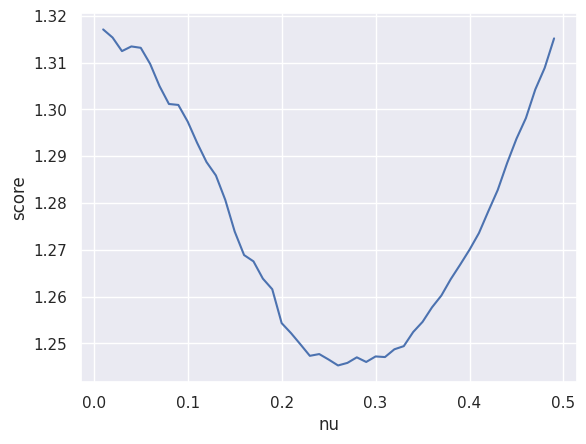

In [157]:
scores = []
for nu in tqdm(array_of_percentage_anchor_points):
    nu_svc = NuSVC(nu=nu, probability=True)
    nu_svc.fit(X_train, y_train)
    probs = nu_svc.predict_proba(X_test)
    
    loss = log_loss(y_test, probs)
    scores.append(loss)

plot_score(array_of_percentage_anchor_points, scores, 'nu')

### Нейронные сети

#### Базовая модель

Возьмем в качестве модели многослойный перцептрон, для борьбы с переобучением
воспользуемся слоями `Dropout`. Кроме того, добавим между слоями
нормализацию по подвыборке для того, чтобы сгладить процесс обучения.

В качестве функции активации выберем `leaky_relu`.

In [ ]:
from keras.layers import Input, Dropout, Dense, BatchNormalization

clear_session()

lr = 0.001

model = keras.Sequential()
model.add(Input(X_train.shape[1]))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.3))

model.add(Dense(128, activation='leaky_relu'))
model.add(Dropout(.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(8, activation='softmax'))


model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()

In [ ]:
np.unique(y_train)

In [ ]:
nn_y_train = np.array(list(map(label2vec(n_classes), y_train)))
nn_y_test = np.array(list(map(label2vec(n_classes), y_test)))
nn_y_valid = np.array(list(map(label2vec(n_classes), y_valid)))

In [ ]:
run = input()

callbacks = [
  TensorBoard(),
  ModelCheckpoint(f'{run}/checkpoint/', save_best_only=True, save_weights_only=True, monitor='categorical_accuracy', verbose=1),
  CSVLogger("logs.csv")
]

In [ ]:
model.fit(X_train, nn_y_train, validation_data=(X_valid, nn_y_valid), epochs=200, callbacks=callbacks, batch_size=128)

In [ ]:
model.load_weights(f'{run}/checkpoint/')
model.evaluate(X_test, nn_y_test)

In [ ]:
models.append((model, 'keras'))

### Сравнение моделей, обученных на мета-данных

In [ ]:
for entry in models:
  model_type = entry[1]
  model = entry[0]
  if model_type == 'sklearn':
    model.fit(X_train, y_train)
    results = model.score(X_test, y_test)
  else:
    results = model.evaluate(X_test, nn_y_test)
  print(f'Результат для {model.__class__.__name__}: {results}')

### Сверточная нейронная сеть

In [ ]:
def get_audio_by_id(id, sr=22050):
  id = f'{id:06}'
  subfolder = id[:3]
  filename = f'{DATA_DIR}/{subfolder}/{id}.mp3'
  return librosa.load(filename, sr=sr)[0]

In [ ]:
import os.path as path
import glob
from tqdm import tqdm

from tempfile import mkdtemp, gettempdir
from itertools import islice


@dataclass
class AudioLoader(Sequence):
  data: pd.DataFrame
  sr: int = 22050
  batch_size: int = 16
  n_fft: int = 2048
  hop_length: int = 512
  suffix: int = None
  
  x = None
  y = None
  dtemp = None
  
  def retrieve_image(spec):
    fig = plt.figure(frameon=False)
    ax = fig.add_subplot(111)
    ax.set_position([0, 0, 1, 1])
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.patch.set_alpha(0)
    
    librosa.display.specshow(spec, ax=ax)
    fig.canvas.draw()
    rgba_buf = fig.canvas.buffer_rgba()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.frombuffer(rgba_buf, dtype=np.uint8).reshape((h, w, 4))[:, :, :3]
    plt.close()
    
    return rgba_arr / 255
  
  def __restore_state__(self):
    try:
      with open(f'{self.dtemp}/.progress{self.suffix}', 'r') as f:
        i = int(f.read())
    except OSError:
      i = 0
    return i
  
  def __save_state__(self, i):
    path = f'{self.dtemp}/.progress{self.suffix}'
    with open(path, 'w') as f:
      f.write(str(i))
  
  def __post_init__(self):
    try:
      dtemp = glob.glob(f'/{gettempdir()}/genre-research*{self.suffix}')[0]
      self.dtemp = dtemp
      mode = 'r+'
    except:
      self.dtemp = mkdtemp(prefix='genre-research', suffix=self.suffix)
      mode = 'w+'
  
    self.x = np.memmap(path.join(self.dtemp, 'x.dat'),
                       shape=(8000, 480, 640, 3),
                       dtype=np.float32,
                       mode=mode)
    self.y = np.memmap(path.join(self.dtemp, 'y.dat'),
                       shape=(8000, 8),
                       dtype=np.float32,
                       mode=mode)
    
    init_state = self.__restore_state__()
    i = init_state
    for index, row in tqdm(islice(self.data.iterrows(), init_state, None, 1), total=len(self.data), initial=init_state):
      if i % 100 == 0:
        self.__save_state__(i)
      
      try:
        audio = get_audio_by_id(index)
      except Exception:
        self.x[i] = np.zeros((480, 640, 3))
        self.y[i] = np.zeros(8)
        i += 1
        continue
      audio = np.pad(audio, (0, max(self.sr * 31 - audio.shape[0], 0)))
      spec = librosa.power_to_db(
        librosa.feature.melspectrogram(y=audio, 
                                        n_fft=self.n_fft, 
                                        hop_length=self.hop_length,
                                        fmax=8000))
      
      image = AudioLoader.retrieve_image(spec)
      self.x[i] = image
      self.y[i] = label2vec(8)(int(row['track_genres']))
      i += 1
    
    self.__save_state__(str(len(self.data)))
    p = np.random.permutation(self.data.shape[0])
    self.x, self.y = self.x[p], self.y[p]
    
  def __len__(self):
    return self.data.shape[0] // self.batch_size
  
  def __getitem__(self, index):
    x_cur = self.x[self.batch_size * index:self.batch_size * (index + 1)]
    y_cur = self.y[self.batch_size * index:self.batch_size * (index + 1)]
    
    return x_cur, y_cur
  
  def on_epoch_end(self):
    p = np.random.permutation(self.data.shape[0])
    self.x, self.y = self.x[p], self.y[p]

In [ ]:
batch_size=32

In [ ]:
train = pd.DataFrame(columns=selected.columns)
valid = pd.DataFrame(columns=selected.columns)
test = pd.DataFrame(columns=selected.columns)

train_size = 0.8
valid_size = 0.1

for i in range(0, 8):
  cur = selected[selected['track_genres'] == i]
  
  n = len(cur)
  train = pd.concat([train, cur.iloc[:int(train_size * n)]])
  valid = pd.concat([valid, cur.iloc[int(train_size * n):int((train_size + valid_size) * n)]])
  test = pd.concat([test, cur.iloc[int((train_size + valid_size) * n):]])


In [ ]:
test_loader = AudioLoader(test, suffix='_test', batch_size=batch_size)

In [ ]:
val_loader = AudioLoader(valid, suffix='_val', batch_size=batch_size)

In [ ]:
train_loader = AudioLoader(train, suffix='_train', batch_size=batch_size)

In [ ]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dense, Dropout
from keras.backend import clear_session
from keras.regularizers import L2

from keras.applications import ResNet50

clear_session()

model = Sequential()

resnet50 = ResNet50(include_top=False, input_shape=(480, 640, 3))

resnet50.trainable = False

model.add(resnet50)
model.add(Conv2D(32, (4, 4), strides=(2, 2),
                 activation='relu',
                 kernel_regularizer=L2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# model.add(Conv2D(16, (8, 8), strides=(4, 4), activation='relu',
#                  kernel_regularizer=L2(0.01)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['categorical_accuracy'])

model.summary()

In [ ]:
callbacks = [
  ModelCheckpoint("model/checkpoint", monitor='val_categorical_accuracy', 
                  save_best_only=True, save_weights_only=True),
  BackupAndRestore("backup"),
  CSVLogger("logs.csv"),
  TensorBoard()
]

In [ ]:
model.fit(train_loader, validation_data=val_loader,
          batch_size=batch_size, epochs=150,
          callbacks=callbacks, shuffle=True)